In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization, InputLayer, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.mixed_precision import LossScaleOptimizer
from tensorflow.keras.metrics import Recall
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import random
import os
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import random

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
data_dir = "/content/drive/My Drive/Malaria-Detection/Dataset1"

In [ ]:
model1 = Sequential()
model1.add(InputLayer(input_shape=(227,227,3),name ="Input"))
model1.add(Conv2D(96, 4 , activation='relu', padding= "valid", name ="Conv2d_1"))
model1.add(BatchNormalization(name="BatchNorm_1"))
model1.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid', name = "MaxPool_1"))
model1.add(Conv2D(256, 1, padding ="same", activation='relu', name="Conv2d_2"))
model1.add(BatchNormalization(name="BatchNorm_2"))
model1.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid', name="MaxPool_2"))
model1.add(Conv2D(384,1, padding ="same", activation='relu', name = "Conv2d_3"))
model1.add(Conv2D(384,1, padding ="same", activation='relu', name="Conv2d_4"))
model1.add(Conv2D(256, 4, activation='relu', padding= "valid", name="Conv2d_5"))
model1.add(BatchNormalization(name="BatchNorm_3"))
model1.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid', name="MaxPool_3"))
model1.add(Conv2D(384,1, padding ="same", activation='relu', name = "Conv2d_6"))
model1.add(Conv2D(384,1, padding ="same", activation='relu', name="Conv2d_7"))
model1.add(Conv2D(256, 4, activation='relu', padding= "valid", name="Conv2d_8"))
model1.add(BatchNormalization(name="BatchNorm_9"))
model1.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid', name="MaxPool_4"))
model1.add(Flatten(name="Flatten_1"))
model1.add(Dense(409, activation='relu',name="Dense_1"))
model1.add(Dropout(0.25, name="Dropout_1"))
model1.add(Dense(409, activation='relu', name="Dense_2"))
model1.add(Dropout(0.25, name="Dropout_2"))
model1.add(Dense(409, 
                 activation='relu',
                 kernel_initializer='random_normal',
                 bias_initializer='zeros',
                 name="Dense_3"
                 ))
model1.add(Dropout(0.5, name = "Dropout_3"))
model1.add(Dense(2,
                 activation="softmax",
                 kernel_initializer='random_normal',
                 bias_initializer='zeros',
                 name="Dense_4"
                 ))




In [ ]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2d_1 (Conv2D)           (None, 224, 224, 96)      4704      
                                                                 
 BatchNorm_1 (BatchNormaliza  (None, 224, 224, 96)     384       
 tion)                                                           
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 111, 111, 96)      0         
                                                                 
 Conv2d_2 (Conv2D)           (None, 111, 111, 256)     24832     
                                                                 
 BatchNorm_2 (BatchNormaliza  (None, 111, 111, 256)    1024      
 tion)                                                           
                                                                 
 MaxPool_2 (MaxPooling2D)    (None, 55, 55, 256)      

In [ ]:
opt = SGD(learning_rate=0.001, momentum=0.52)
opt = LossScaleOptimizer(opt)


#https://www.kaggle.com/code/salokr/a-simple-cnn-knn-based-model-to-get-99-score/notebook


In [ ]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.52)

opt1 = SGD(learning_rate=0.001,momentum=0.5, decay=0.5)
opt1 = LossScaleOptimizer(opt1)


In [ ]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.5)
opt2 = RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.01,
    epsilon=1e-07,
    centered=True
)
opt2 = LossScaleOptimizer(opt2)


In [ ]:
opt3 = Adagrad(
    learning_rate=0.001,
    initial_accumulator_value=0.1,
    epsilon=1e-07,
    name="Adagrad",
)
opt3 = LossScaleOptimizer(opt3)


In [ ]:
model1.compile(
  loss= 'categorical_crossentropy',
  # optimizer= opt,
  # optimizer= opt1,
  # optimizer= opt2,
  optimizer= opt3,

  # metrics=[Recall()]
  metrics = ['accuracy']
)

In [ ]:
# folders = glob('/Users/rutujajadhav/Desktop/r/Dataset/Train/*')
folders = glob('/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/*')
folders

['/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/Uninfected',
 '/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/Parasite']

In [ ]:
# PARA_DIR = "/Users/rutujajadhav/Desktop/r/Dataset/Train/Parasite/"
PARA_DIR = "/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/Parasite/"
# UNIF_DIR =  "/Users/rutujajadhav/Desktop/r/Dataset/Train/Uninfected/"
UNIF_DIR = "/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/Uninfected/"

In [ ]:
Pimages = os.listdir(PARA_DIR)
Nimages = os.listdir(UNIF_DIR)

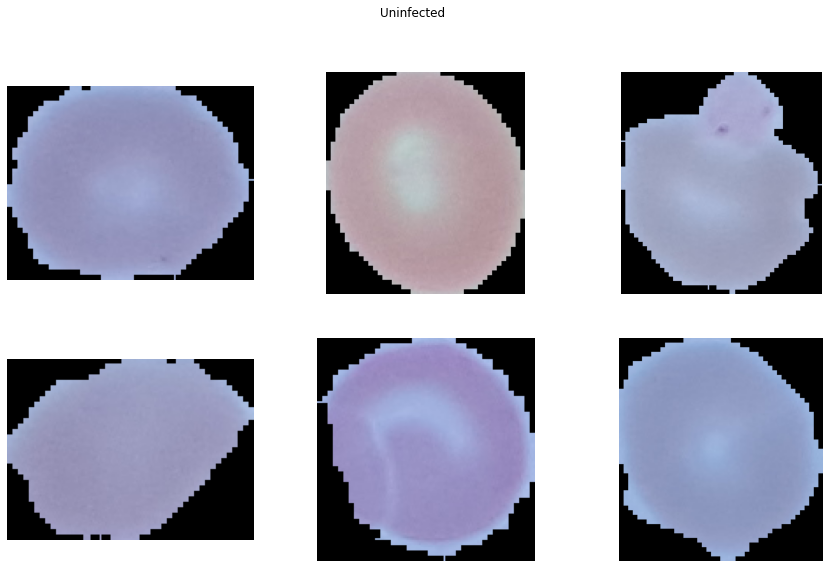

In [ ]:
sample_normal = random.sample(Nimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    # im = cv2.imread('/Users/rutujajadhav/Desktop/r/Dataset/Train/Uninfected/'+sample_normal[i])
    im = cv2.imread('/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/Uninfected/'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Uninfected')
plt.show()

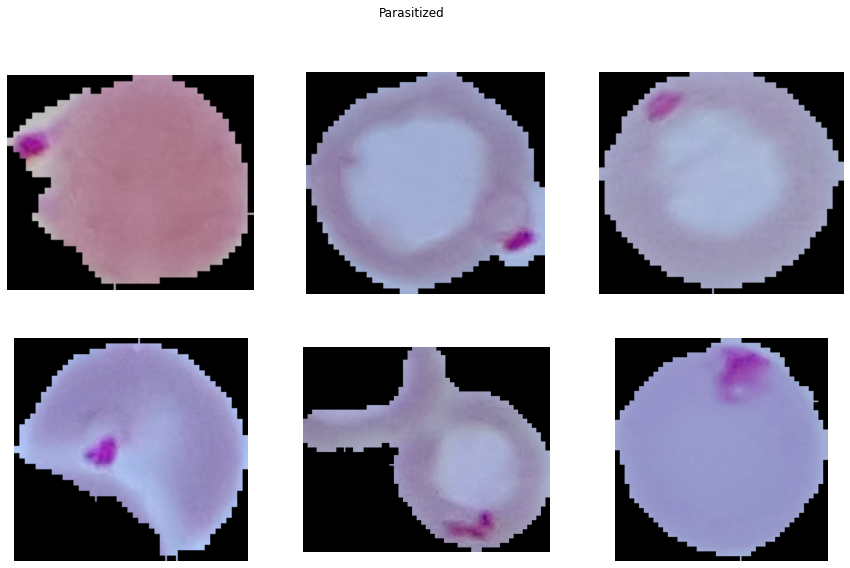

In [ ]:
sample_parasite = random.sample(Pimages,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    # im = cv2.imread('/Users/rutujajadhav/Desktop/r/Dataset/Train/Parasite/'+sample_parasite[i])
    im = cv2.imread('/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/Parasite/'+sample_parasite[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Parasitized')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                  validation_split=0.2) # set validation split

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set_all = train_datagen.flow_from_directory('/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/',
                                                 target_size = (227, 227),
                                                 batch_size = 20,
                                                 class_mode = 'categorical')

Found 416 images belonging to 2 classes.


In [ ]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/',
                                                 target_size = (227, 227),
                                                 batch_size = 20,
                                                 class_mode = 'categorical',
                                                     subset='training') # set as training data

Found 333 images belonging to 2 classes.


In [ ]:
validation_data = train_datagen.flow_from_directory('/content/drive/MyDrive/Malaria-Detection/Dataset1/Train/',
                                                 target_size = (227, 227),
                                                 batch_size = 20,
                                                 class_mode = 'categorical',
                                                     subset='validation') # set as validation data

Found 83 images belonging to 2 classes.


In [ ]:
test_set1 = test_datagen.flow_from_directory('/content/drive/MyDrive/Malaria-Detection/Dataset1/Test/',
                                            target_size = (227, 227),
                                            batch_size = 20,
                                            class_mode = 'categorical',
                                            shuffle= False)

Found 134 images belonging to 2 classes.


In [ ]:
print('Training Data : '+str(training_set.__len__()))
print('Validation Data : '+str(validation_data.__len__()))

print('Test Data : '+str(test_set1.__len__()))


Training Data : 17
Validation Data : 5
Test Data : 7


In [ ]:
from tensorflow.keras.models import load_model

r1 = model1.fit(
  training_set,
  validation_data= validation_data,
  epochs=40,
  batch_size = 20,
  steps_per_epoch=len(training_set),
  # validation_steps=len(validation_data),
  workers=20
)

# model1.save('/content/drive/MyDrive/Malaria-Detection/model3_CNN.h5')

# import pickle
# pickle.dump(model1, open('/content/drive/MyDrive/Malaria-Detection/model3_CNN.pkl', 'wb'))

Epoch 1/40
17/17 [==============================] - 16s 824ms/step - loss: 0.0452 - accuracy: 0.9850 - val_loss: 0.0958 - val_accuracy: 0.9639
Epoch 2/40
17/17 [==============================] - 16s 811ms/step - loss: 0.0376 - accuracy: 0.9910 - val_loss: 0.0795 - val_accuracy: 0.9759
Epoch 3/40
17/17 [==============================] - 16s 819ms/step - loss: 0.0219 - accuracy: 0.9910 - val_loss: 0.0568 - val_accuracy: 0.9880
Epoch 4/40
17/17 [==============================] - 16s 820ms/step - loss: 0.0346 - accuracy: 0.9880 - val_loss: 0.0896 - val_accuracy: 0.9759
Epoch 5/40
17/17 [==============================] - 16s 818ms/step - loss: 0.0351 - accuracy: 0.9880 - val_loss: 0.0927 - val_accuracy: 0.9639
Epoch 6/40
17/17 [==============================] - 16s 816ms/step - loss: 0.0296 - accuracy: 0.9880 - val_loss: 0.1036 - val_accuracy: 0.9759
Epoch 7/40
17/17 [==============================] - 16s 815ms/step - loss: 0.0250 - accuracy: 0.9910 - val_loss: 0.1115 - val_accuracy: 0.9639

In [ ]:

model1.save('/content/drive/MyDrive/Malaria-Detection/model4_op3_CNN.h5')

import pickle
pickle.dump(model1, open('/content/drive/MyDrive/Malaria-Detection/model4_op3_CNN.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://b3f30e21-df31-4a50-b807-fd96e6b27563/assets


INFO:tensorflow:Assets written to: ram://b3f30e21-df31-4a50-b807-fd96e6b27563/assets


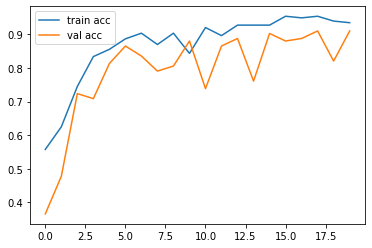

In [ ]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

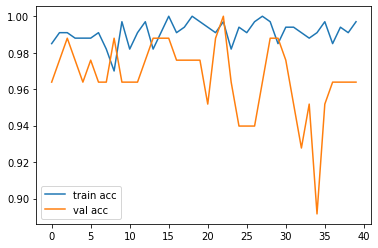

In [ ]:
plt.plot(r1.history['accuracy'], label='train acc')
plt.plot(r1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model.save('model2_vgg19.h5')

In [ ]:
print('Training Data : '+str(training_set.__len__()))
print('Test Data : '+str(test_set1.__len__()))


Training Data : 17
Test Data : 7


In [ ]:
from tensorflow.keras.models import load_model
classifier =load_model('/content/drive/MyDrive/Malaria-Detection/model4_op3_CNN.h5')

In [ ]:
y_pred = classifier.predict(test_set1)

In [ ]:
y_pred1=np.argmax(y_pred, axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

print(confusion_matrix(test_set1.classes, y_pred1))


[[61 30]
 [ 0 43]]


In [ ]:
print(classification_report(test_set1.classes, y_pred1))


              precision    recall  f1-score   support

           0       1.00      0.67      0.80        91
           1       0.59      1.00      0.74        43

    accuracy                           0.78       134
   macro avg       0.79      0.84      0.77       134
weighted avg       0.87      0.78      0.78       134



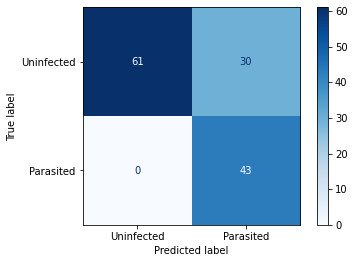

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
labels = ["Uninfected", "Parasited"]
cm = confusion_matrix(test_set1.classes, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [ ]:
classifier.evaluate(test_set1)


7/7 [==============================] - 2s 160ms/step - loss: 0.8267 - accuracy: 0.7761


[0.8267231583595276, 0.7761194109916687]

In [ ]:
from tensorflow.keras.models import load_model
classifier1 =load_model('/content/drive/MyDrive/Malaria-Detection/model4_op3_CNN.h5')
def predict_output(img):
  # img=image.load_img('/content/drive/MyDrive/Malaria-Detection/TestImages/C39P4thinF_original_IMG_20150622_105335_cell_15.png',target_size=(227,227))
  x=image.img_to_array(img)
  x=x/255
  x=np.expand_dims(x,axis=0)
  a=np.argmax(classifier1.predict(x), axis=1)
  if(a==1):
    return "Uninfected"
  else:
    return "Infected"

In [ ]:
TestImages = os.listdir('/content/drive/MyDrive/Malaria-Detection/TestImages')


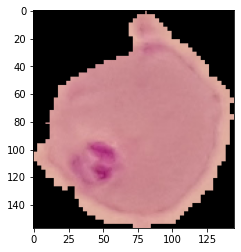

Infected




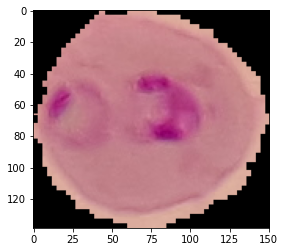

Infected




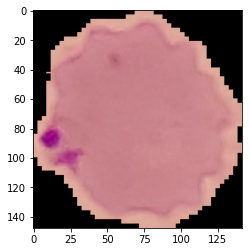

Infected




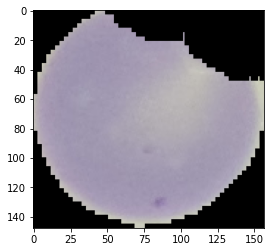

Uninfected




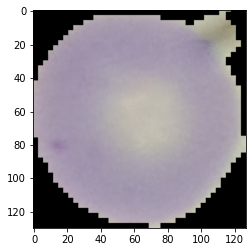

Uninfected




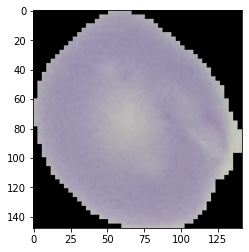

Uninfected




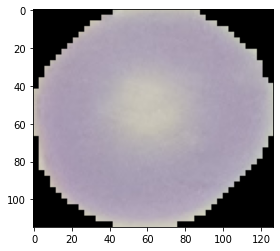

Uninfected




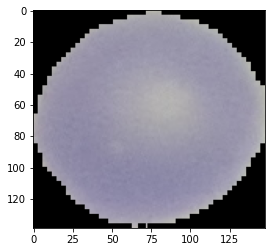

Uninfected




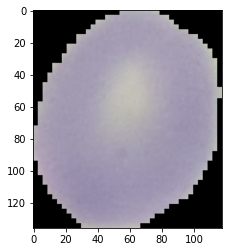

Uninfected




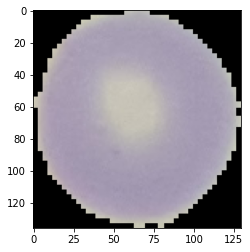

Uninfected




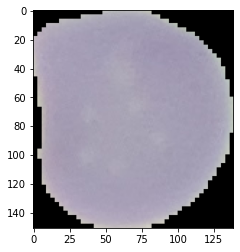

Uninfected




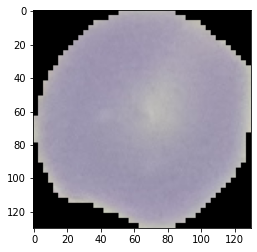

Uninfected




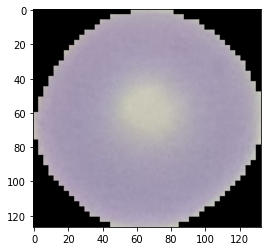

Uninfected




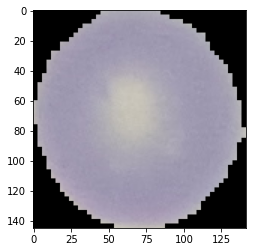

Uninfected




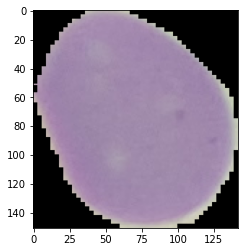

Uninfected




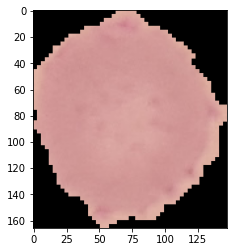

Uninfected




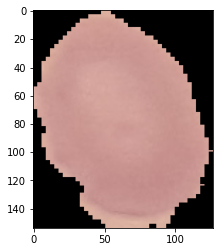

Uninfected




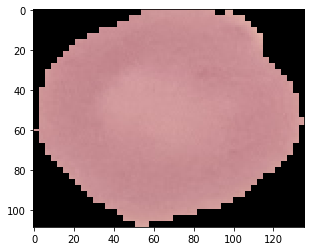

Uninfected




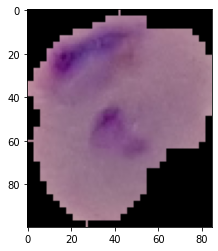

Infected




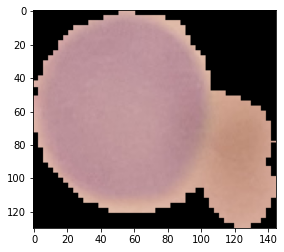

Uninfected




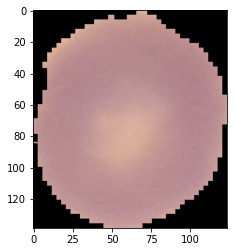

Uninfected




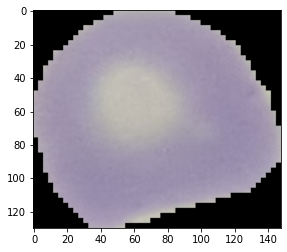

Uninfected




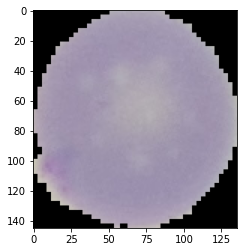

Uninfected




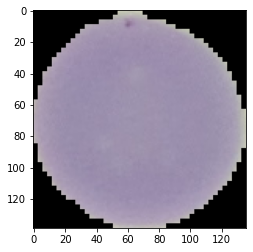

Uninfected




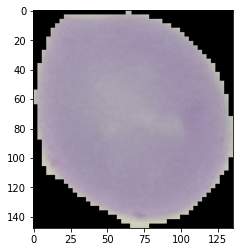

Uninfected




In [ ]:

for i in range(len(TestImages)):
  if(TestImages[i].endswith('.jpg') or TestImages[i].endswith('.png')):
    img = image.load_img('/content/drive/MyDrive/Malaria-Detection/TestImages/'+TestImages[i],target_size=(227,227))
    im_cv = cv2.imread('/content/drive/MyDrive/Malaria-Detection/TestImages/'+TestImages[i])
    im_rgb = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)

    plt.imshow(im_rgb)
    plt.show()
    print(predict_output(img))
    print("\n")


In [ ]:
# visualize confusion matrix on heat map
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sn.heatmap(df_cmx, annot=True)
    plt.show()


In [ ]:
from tensorflow.keras.models import Model
new_model=Model(inputs=classifier.input,outputs=classifier.get_layer('Dropout_2').output)
#Let's obtain the Input Representations
train_set=new_model.predict(training_set)
test_set=new_model.predict(test_set1)
#Convert back the labels
#We are now going to have a single row for each example
# TO CHANGE
# train_set=train_set.reshape(42000,5*5*64)
# test_set=test_set.reshape(28000,5*5*64)

In [ ]:
print(train_set.shape)
print(test_set.shape)

(333, 409)
(134, 409)


In [ ]:
x_train_all=np.concatenate([training_set_all.next()[0] for i in range(training_set_all.__len__())])
y_train_all=np.concatenate([training_set_all.next()[1] for i in range(training_set_all.__len__())])

In [ ]:
x_train=np.concatenate([training_set.next()[0] for i in range(training_set.__len__())])
y_train=np.concatenate([training_set.next()[1] for i in range(training_set.__len__())])

In [ ]:
x_train_2=np.concatenate([validation_data.next()[0] for i in range(validation_data.__len__())])
y_train_2=np.concatenate([validation_data.next()[1] for i in range(validation_data.__len__())])

In [ ]:
x_test=np.concatenate([test_set1.next()[0] for i in range(test_set1.__len__())])
y_test=np.concatenate([test_set1.next()[1] for i in range(test_set1.__len__())])

In [ ]:
x_train_all_features = new_model.predict(x_train_all)
x_train_features = new_model.predict(x_train)
x_train_2_features = new_model.predict(x_train_2)
x_test_features = new_model.predict(x_test)


In [ ]:
print(y_test)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 

In [ ]:
for i in test_set1.filenames:
    print(i)

Parasite/C39P4thinF_original_IMG_20150622_105554_cell_10.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_11.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_12.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_13.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_14.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_15.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_16.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_17.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_18.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_19.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_20.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_21.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_22.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_23.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_24.png
Parasite/C39P4thinF_original_IMG_20150622_105554_cell_25.png
Parasite/C39P4thinF_orig

In [ ]:
y_train_all_flat = np.argmax(y_train_all, axis=1)
y_train_flat = np.argmax(y_train, axis=1)
y_train_2_flat = np.argmax(y_train_2, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

In [ ]:
print(y_test_flat)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
print(x_train_all_features.shape ,x_train_features.shape, x_train_2_features.shape, x_test_features.shape)
print(y_train_all_flat.shape, y_train_flat.shape, y_train_2_flat.shape, y_test_flat.shape)

(416, 409) (333, 409) (83, 409) (134, 409)
(416,) (333,) (83,) (134,)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parameters = {"n_neighbors": [1, 5, 10, 30, 32, 64, 86],
              "weights": ['uniform'],
              "metric": ['minkowski'],
              "leaf_size":[1,3, 10, 20],
              "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
              "p":[1,2,10,15,20]
              }
kclf = KNeighborsClassifier()
kgclf = GridSearchCV(kclf, param_grid=parameters, cv=10, scoring='accuracy', return_train_score=False,verbose=1, refit=True)

kgclf.fit(x_train_all_features, y_train_all)

Fitting 10 folds for each of 560 candidates, totalling 5600 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [1, 3, 10, 20], 'metric': ['minkowski'],
                         'n_neighbors': [1, 5, 10, 30, 32, 64, 86],
                         'p': [1, 2, 10, 15, 20], 'weights': ['uniform']},
             scoring='accuracy', verbose=1)

In [ ]:
kclf = kgclf.best_estimator_
kclf.fit(x_train_all_features, y_train_all)

KNeighborsClassifier(leaf_size=1)

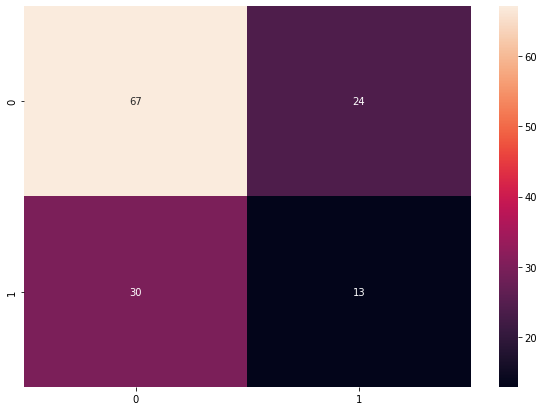

              precision    recall  f1-score   support

           0       0.69      0.74      0.71        91
           1       0.35      0.30      0.32        43

    accuracy                           0.60       134
   macro avg       0.52      0.52      0.52       134
weighted avg       0.58      0.60      0.59       134

Accuracy: 0.5970149253731343


In [ ]:

y_test_KNN = kclf.predict(x_test_features)
y_test_KNNflat = np.argmax(y_test_KNN, axis=1)


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print_cmx(y_test_flat.T, y_test_KNNflat)
print(classification_report(y_test_flat, y_test_KNNflat))
print("Accuracy: {0}".format(accuracy_score(y_test_flat, y_test_KNNflat)))


In [ ]:
def predict_KNN_output(img):
  # img=image.load_img('/content/drive/MyDrive/Malaria-Detection/TestImages/C39P4thinF_original_IMG_20150622_105335_cell_15.png',target_size=(227,227))
  x=image.img_to_array(img)
  x=x/255
  x=np.expand_dims(x,axis=0)
  features=new_model.predict(x)
  a=np.argmax(kclf.predict(features), axis=1)
  if(a==1):
    return "Uninfected"
  else:
    return "Infected"

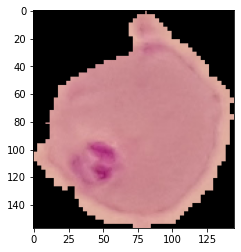

Uninfected




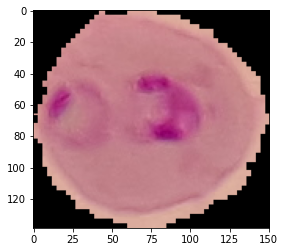

Uninfected




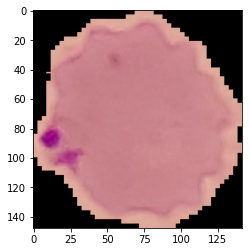

Infected




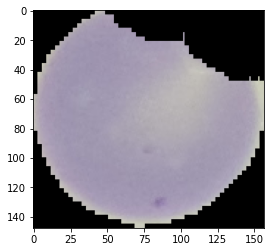

Infected




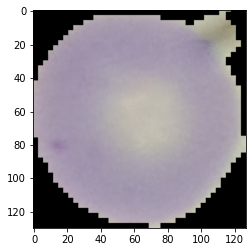

Infected




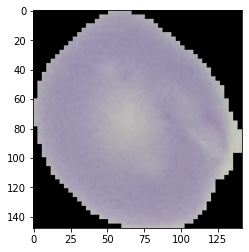

Infected




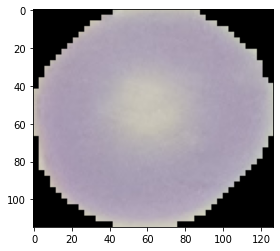

Infected




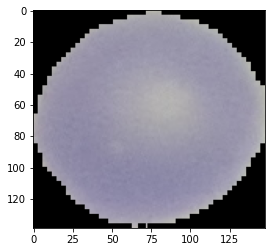

Infected




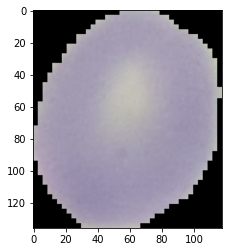

Infected




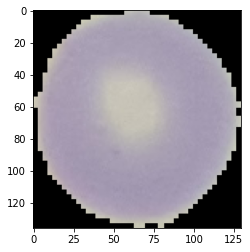

Infected




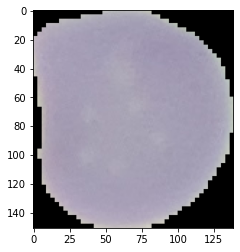

Uninfected




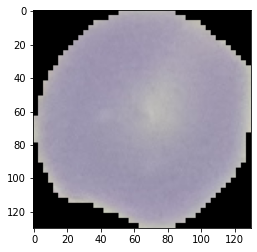

Infected




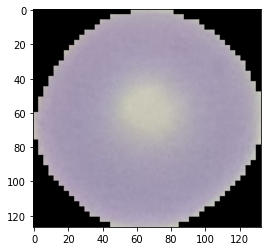

Infected




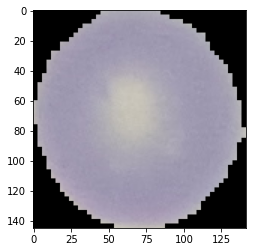

Infected




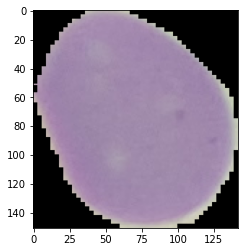

Uninfected




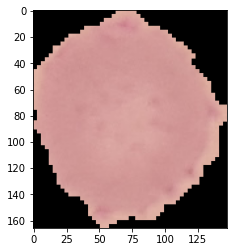

Uninfected




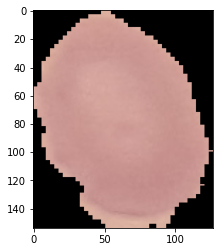

Infected




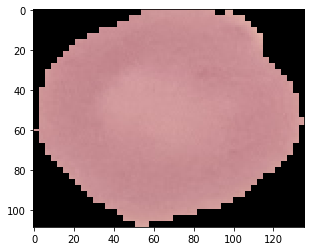

Infected




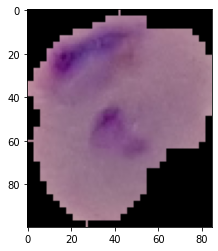

Uninfected




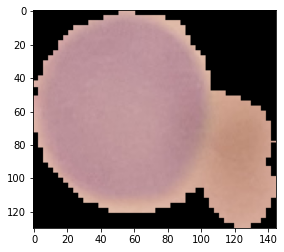

Infected




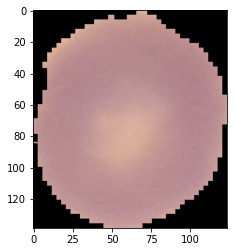

Infected




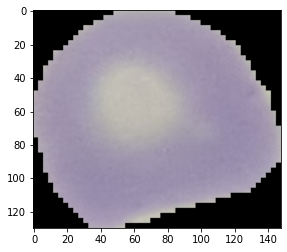

Infected




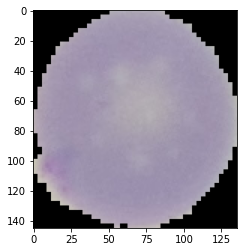

Infected




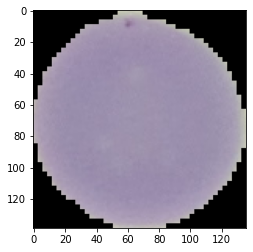

Uninfected




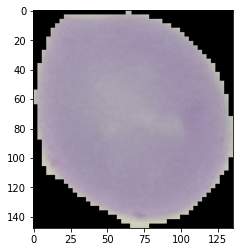

Uninfected




In [ ]:

for i in range(len(TestImages)):
  if(TestImages[i].endswith('.jpg') or TestImages[i].endswith('.png')):
    img = image.load_img('/content/drive/MyDrive/Malaria-Detection/TestImages/'+TestImages[i],target_size=(227,227))
    im_cv = cv2.imread('/content/drive/MyDrive/Malaria-Detection/TestImages/'+TestImages[i])
    im_rgb = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)

    plt.imshow(im_rgb)
    plt.show()
    print(predict_KNN_output(img))
    print("\n")
